# LDED Audiovisual Fusion 

Author: Chen Lequn.
Created on 10 Oct 2023.

- Material: Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Recorded data: position, veolocity, coaxial ccd features, acoustic feature
- Quality labels generated: keyhole pores, cracks, defect-free

### Notebook 2b: Spatio-temporal feature registration
- __Register features, image, audio slices, and their features with the corresponding location/velocity data on the same  time stamps__ 


In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

In [2]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'feature_extraction')
os.makedirs(IMAGE_PATH, exist_ok=True)

Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')
                            

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [3]:
def get_sample_directories(base_path, sample_numbers):
    sample_directories = []
    for sample_number in sample_numbers:
        sample_directories.append(os.path.join(base_path, f'{sample_number}'))
    return sample_directories


samples = [21, 22, 23, 24, 26, 32]
sample_directories = get_sample_directories(Dataset_path, samples)

# Get lists of image and audio directories for each sample
image_directories = [os.path.join(sample_dir, 'images') for sample_dir in sample_directories]
audio_directories = [os.path.join(sample_dir, 'raw_audio') for sample_dir in sample_directories]

In [4]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'data_audiovisual_with_annotations(raw_audio).h5'), key='df')
# df_multimodal = df_multimodal.dropna(subset=['class_name'])
df_multimodal

,sample_index,sample_number,sony_image_file_name,number_of_spatters,total_area_of_spatters,average_intensity_per_pixel,vapour_plume_detected,audio_file_name,image_file_name,Layer number,...,nu11,nu02,nu30,nu21,nu12,nu03,center_x,center_y,contour_area,contour_length
0,1,NaN,NaN,NaN,NaN,NaN,False,sample_21_1.wav,sample_21_1.jpg,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2,NaN,NaN,NaN,NaN,NaN,False,sample_21_2.wav,sample_21_2.jpg,1.0,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
2,3,NaN,NaN,NaN,NaN,NaN,False,sample_21_3.wav,sample_21_3.jpg,1.0,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
3,4,NaN,NaN,NaN,NaN,NaN,False,sample_21_4.wav,sample_21_4.jpg,1.0,...,-0.008049,0.062216,0.001940,-0.002304,-0.001599,0.000891,307.440996,230.264496,291865.5,2279.781744
4,5,NaN,NaN,NaN,NaN,NaN,False,sample_21_5.wav,sample_21_5.jpg,1.0,...,-0.009879,0.065910,0.001738,-0.003345,-0.000898,0.001388,296.636877,229.109962,281970.0,2407.847760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62002,13525,32.0,sample_32_13525.png,26.0,622.0,15.476772,False,sample_32_13525.wav,sample_32_13525.jpg,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
62003,13526,32.0,sample_32_13526.png,26.0,608.0,15.493593,False,sample_32_13526.wav,sample_32_13526.jpg,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
62004,13527,32.0,sample_32_13527.png,23.0,631.0,15.442738,False,sample_32_13527.wav,sample_32_13527.jpg,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
62005,13528,32.0,sample_32_13528.png,24.0,597.5,15.454680,False,sample_32_13528.wav,sample_32_13528.jpg,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


# Data cleaning

## Load a single position dataset for inspection and cleaning

In [5]:
sample_num = 23

In [6]:
# Load the CSV file into a Pandas DataFrame
file_path = os.path.join(Dataset_path, f'{sample_num}', 'position_23_raw.csv') 
df_position_23_raw = pd.read_csv(file_path)
df_position_23_raw

,Time_1,field.X,field.Y,field.Z,field.A,field.B,field.C,%time,Time_2,field.Vx,field.Vy,field.Vz,field.Speed
0,0.00000,2982.488037,-1740.239624,918.886475,-90.109703,-0.5230,178.020004,1.655980e+18,0.00000,0.049177,-0.172119,0.270473,0.324344
1,0.00405,2982.487549,-1740.239502,918.886231,-90.109703,-0.5230,178.020004,1.655980e+18,0.00406,-0.125450,0.025090,-0.075270,0.148435
2,0.00823,2982.487549,-1740.239624,918.886475,-90.109802,-0.5231,178.020004,1.655980e+18,0.00825,0.000000,-0.024723,0.074170,0.078182
3,0.01223,2982.487305,-1740.239624,918.886231,-90.109802,-0.5230,178.020004,1.655980e+18,0.01224,-0.048391,0.000000,-0.072587,0.087238
4,0.01594,2982.487793,-1740.239380,918.886231,-90.109802,-0.5230,178.020004,1.655980e+18,0.01593,0.129366,0.051746,0.000000,0.139331
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113908,455.62578,2982.488037,-1740.251709,938.517883,-90.108597,-0.5256,178.018799,1.655980e+18,455.62579,-0.122583,-0.171616,0.098066,0.232585
113909,455.62973,2982.487793,-1740.251099,938.517273,-90.108597,-0.5255,178.018799,1.655980e+18,455.62973,-0.050892,0.152677,-0.152677,0.221835
113910,455.63378,2982.487793,-1740.251709,938.517578,-90.108597,-0.5256,178.018799,1.655980e+18,455.63378,0.000000,-0.151583,0.075792,0.169475
113911,455.63896,2982.488770,-1740.251099,938.517517,-90.108597,-0.5256,178.018799,1.655980e+18,455.63897,0.245971,0.147583,-0.024597,0.287902


1. Remove the columns A, B, and C.
2. Synchronize the time axes __Time_1__ and __Time_2__. (__Not necessary__)
3. Rename the columns to remove the "field" prefix and unify the dataset.
4. Offset the X,Y,Z positions by the value of the first row.
5. Move the synchronized time column to the first column in the DataFrame.

### time-sync algorithm: 

- finds the closest time stamp from the second column for each entry in the first column.
- Specifically, it iterates through each time stamp in 'Time_1' and finds the closest time stamp in 'Time_2'.
- The closest time stamp is considered the best approximate sync point.

### Function to process raw dataframe

In [7]:
def process_raw_dataframe(df_raw):
    rows_to_drop = range(0, 300)
    # 21 - (0 , 747)
    # 22 - (0, 299)
    # 23 - (0, 279)
    # 24 - (0, 132)
    # 26 - (0, 163)
    # 32 - (0, 282)
    df_cleaned = df_raw.drop(rows_to_drop)
    # Reset the index so it starts from 0
    df_cleaned.reset_index(drop=True, inplace=True)
    
    # Step 2: Remove the columns A, B, and C
    df_cleaned = df_cleaned.drop(columns=['field.A', 'field.B', 'field.C', '%time'])

    # Use Time_1 as Time_Stamp_Spatial
    df_cleaned.rename(columns={'Time_1': 'Time_Stamp_Spatial'}, inplace=True)
    df_cleaned.drop(columns=['Time_2'], inplace=True)

    # Step 4: Offset the X, Y, Z positions by the value of the first row
    first_row = df_cleaned.iloc[0]
    df_cleaned['field.X'] -= first_row['field.X']
    df_cleaned['field.Y'] -= first_row['field.Y']
    df_cleaned['field.Z'] -= first_row['field.Z']
    df_cleaned['Time_Stamp_Spatial'] -= first_row['Time_Stamp_Spatial']

    # Step 5: Rename the columns
    column_rename_map = {
        'field.X': 'X',
        'field.Y': 'Y',
        'field.Z': 'Z',
        'field.Vx': 'Vx',
        'field.Vy': 'Vy',
        'field.Vz': 'Vz',
        'field.Speed': 'Speed'
    }
    df_cleaned.rename(columns=column_rename_map, inplace=True)

    # Step 6: Move the synchronized time column to be the first column
    column_order = ['Time_Stamp_Spatial'] + [col for col in df_cleaned.columns if col != 'Time_Stamp_Spatial']
    df_cleaned = df_cleaned[column_order]

    # Step 7: Round the values to 3 decimal places
    columns_to_round = ['Time_Stamp_Spatial','X', 'Y', 'Z', 'Vx', 'Vy', 'Vz', 'Speed']
    df_cleaned[columns_to_round] = df_cleaned[columns_to_round].round(7)

    return df_cleaned

In [8]:
# Test the corrected function with the provided CSV file
df_position_23_clean = process_raw_dataframe(df_position_23_raw)
df_position_23_clean

,Time_Stamp_Spatial,X,Y,Z,Vx,Vy,Vz,Speed
0,0.00000,0.000000,0.000000,0.000000,18.767750,-1.302968,6.990924,20.069859
1,0.00400,0.076416,-0.005127,0.023865,18.803240,-1.279802,5.882165,19.743343
2,0.00796,0.156250,-0.010010,0.045960,20.151827,-1.210623,5.573910,20.943500
3,0.01207,0.240234,-0.016968,0.069275,21.159182,-1.763265,5.869154,22.028778
4,0.01599,0.327881,-0.025635,0.093994,21.305946,-2.116001,6.007498,22.237598
...,...,...,...,...,...,...,...,...
113608,454.42581,-0.817383,0.031616,19.255371,-0.122583,-0.171616,0.098067,0.232585
113609,454.42976,-0.817627,0.032226,19.254761,-0.050893,0.152677,-0.152677,0.221835
113610,454.43381,-0.817627,0.031616,19.255066,0.000000,-0.151583,0.075791,0.169475
113611,454.43899,-0.816650,0.032226,19.255005,0.245971,0.147583,-0.024597,0.287902


<AxesSubplot:xlabel='Time_Stamp_Spatial'>

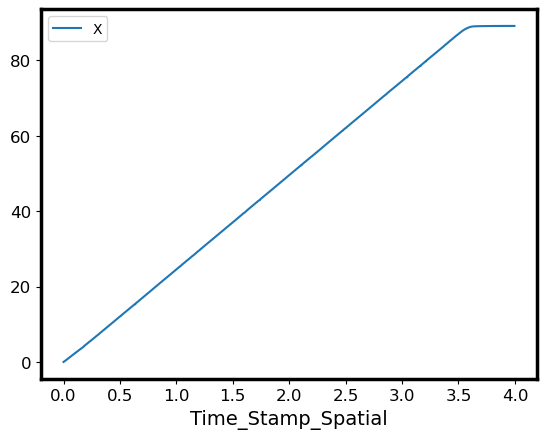

In [9]:
df_position_23_clean[:1000].plot('Time_Stamp_Spatial', 'X')

### Load annotation file for processing

In [47]:
# # Step 1: Read the example annotation file into a Pandas DataFrame
# df_merged_spatter_annotations_21 = pd.read_csv(os.path.join(Dataset_path, '21', 'merged_spatter_annotations_21.csv') )
# df_merged_spatter_annotations_21['Time_Stamp_AudioVisual'] = df_merged_spatter_annotations_21['sample_index'] * 0.04

In [10]:
# Separate the big DataFrame into individual sample DataFrames based on the 'Sample number' column
sample_numbers = [21, 22, 23, 24, 26, 32]
sample_dfs = {sample: df_multimodal[df_multimodal['Sample number'] == sample].reset_index(drop=True) for sample in sample_numbers}

# Display the shape of each individual sample DataFrame to verify the separation
{sample: sample_df.shape for sample, sample_df in sample_dfs.items()}

{21: (5143, 131),
 22: (4624, 131),
 23: (11396, 131),
 24: (16317, 131),
 26: (10986, 131),
 32: (13528, 131)}

In [11]:
for sample, df in sample_dfs.items():
    df['Time_Stamps'] = (df['sample_index'] - 1) * 0.04
    
    # Move Time_Stamps column to the front, right after 'sample index'
    cols = df.columns.tolist()
    cols.insert(1, cols.pop(cols.index('Time_Stamps')))
    sample_dfs[sample] = df[cols]

In [12]:
sample_dfs[23]

,sample_index,Time_Stamps,sample_number,sony_image_file_name,number_of_spatters,total_area_of_spatters,average_intensity_per_pixel,vapour_plume_detected,audio_file_name,image_file_name,...,nu11,nu02,nu30,nu21,nu12,nu03,center_x,center_y,contour_area,contour_length
0,1,0.00,NaN,NaN,NaN,NaN,NaN,False,sample_23_1.wav,sample_23_1.jpg,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2,0.04,NaN,NaN,NaN,NaN,NaN,False,sample_23_2.wav,sample_23_2.jpg,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
2,3,0.08,NaN,NaN,NaN,NaN,NaN,False,sample_23_3.wav,sample_23_3.jpg,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
3,4,0.12,NaN,NaN,NaN,NaN,NaN,False,sample_23_4.wav,sample_23_4.jpg,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
4,5,0.16,NaN,NaN,NaN,NaN,NaN,False,sample_23_5.wav,sample_23_5.jpg,...,-0.011784,0.068768,0.002273,-0.004183,-0.000488,0.001775,288.279973,227.553009,273637.5,2381.320849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11391,11392,455.64,NaN,NaN,NaN,NaN,NaN,False,sample_23_11392.wav,sample_23_11392.jpg,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
11392,11393,455.68,NaN,NaN,NaN,NaN,NaN,False,sample_23_11393.wav,sample_23_11393.jpg,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
11393,11394,455.72,NaN,NaN,NaN,NaN,NaN,False,sample_23_11394.wav,sample_23_11394.jpg,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
11394,11395,455.76,NaN,NaN,NaN,NaN,NaN,False,sample_23_11395.wav,sample_23_11395.jpg,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [13]:
# Define a function to find the closest timestamp index in df_position_21_cleaned for each entry in df_merged_spatter_annotations_21
def find_closest_time_stamp_index(target_time, time_stamps):
    """
    Find the index of the closest time stamp in an array of time stamps.
    
    Parameters:
    - target_time_stamp: The target time stamp to match.
    - time_stamps: An array of time stamps to search.
    
    Returns:
    The index of the closest time stamp.
    """
    # Compute absolute difference
    differences = np.abs(time_stamps - target_time)
    # Return the index of the smallest difference
    return np.argmin(differences)


def synchronize_dataframes(df_audiovisual, df_spatial):
    """
    Synchronize two dataframes based on time stamps and adjust according to specifications.
    
    Parameters:
    - df_audiovisual: DataFrame with audiovisual data, including 'Time_Stamp_AudioVisual'.
    - df_spatial: DataFrame with spatial data, cleaned and processed, including 'Time_Stamp_Spatial'.
    
    Returns:
    The synchronized and adjusted DataFrame.
    """
    # Extract the time stamps from both dataframes
    time_stamps_audiovisual = df_audiovisual['Time_Stamps'].values
    time_stamps_spatial = df_spatial['Time_Stamp_Spatial'].values
    
    # Find the closest index for each time stamp in the audiovisual dataframe
    closest_indices = np.array([find_closest_time_stamp_index(t, time_stamps_spatial) for t in time_stamps_audiovisual])
    
    # Select the corresponding rows from df_spatial
    df_spatial_adjusted = df_spatial.iloc[closest_indices].reset_index(drop=True)
    
    # Adjust df_audiovisual for direct concatenation
    df_audiovisual_adjusted = df_audiovisual.reset_index(drop=True)
    
    # Concatenate the dataframes
    df_synchronized = pd.concat([df_audiovisual_adjusted, df_spatial_adjusted], axis=1)
    
    # Modifications based on requirements
    # df_synchronized = df_synchronized.drop(columns=['Time_Stamp_Spatial'])  # (1)
    df_synchronized = df_synchronized.drop(columns=['sample_number'])  # (1)
    # df_synchronized.rename(columns={'Time_Stamp_AudioVisual': 'Time_Stamp'}, inplace=True)  # (2)
    
    # Re-order columns (3)
    desired_columns = ['sample_index', 'Time_Stamps', 'Time_Stamp_Spatial', 'Sample number', 'Layer number', 
                       "sony_image_file_name", 'audio_file_name', 'image_file_name', 'class_name_v3',
                       'X', 'Y', 'Z', 'Vx', 'Vy', 'Vz', 'Speed']
    # Ensure all other columns are included in the final order
    other_columns = [col for col in df_synchronized.columns if col not in desired_columns]
    df_synchronized = df_synchronized[desired_columns + other_columns]
    
    return df_synchronized


#### Testing purpose

In [15]:
# Extract the time stamps from both dataframes
time_stamps_audiovisual = sample_dfs[21]['Time_Stamps'].values
time_stamps_spatial = df_processed_21['Time_Stamp_Spatial'].values

# Apply the function to find the closest index for each time stamp in the audiovisual dataframe
closest_indices = np.array([find_closest_time_stamp_index(t, time_stamps_spatial) for t in time_stamps_audiovisual])

# Use these indices to select the corresponding rows from df_position_21_cleaned
df_position_closest_adjusted = df_processed_21.iloc[closest_indices].reset_index(drop=True)

# Ensure the indices of df_merged_spatter_annotations_21 match for a direct concatenation
df_merged_adjusted = df_merged_spatter_annotations_21.reset_index(drop=True)

# Concatenate the dataframes
df_synchronized_adjusted = pd.concat([df_merged_adjusted, df_position_closest_adjusted], axis=1)

NameError: name 'df_processed_21' is not defined

In [ ]:
df_synchronized_adjusted

#### Actual usage

In [14]:
df_synchronized_adjusted = synchronize_dataframes(sample_dfs[23], df_position_23_clean)

In [15]:
df_synchronized_adjusted

,sample_index,Time_Stamps,Time_Stamp_Spatial,Sample number,Layer number,sony_image_file_name,audio_file_name,image_file_name,class_name_v3,X,...,nu11,nu02,nu30,nu21,nu12,nu03,center_x,center_y,contour_area,contour_length
0,1,0.00,0.00000,23.0,1.0,NaN,sample_23_1.wav,sample_23_1.jpg,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2,0.04,0.04006,23.0,1.0,NaN,sample_23_2.wav,sample_23_2.jpg,NaN,0.890137,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
2,3,0.08,0.07999,23.0,1.0,NaN,sample_23_3.wav,sample_23_3.jpg,NaN,1.816162,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
3,4,0.12,0.12009,23.0,1.0,NaN,sample_23_4.wav,sample_23_4.jpg,NaN,2.744629,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
4,5,0.16,0.15994,23.0,1.0,NaN,sample_23_5.wav,sample_23_5.jpg,Defect-free,3.670166,...,-0.011784,0.068768,0.002273,-0.004183,-0.000488,0.001775,288.279973,227.553009,273637.5,2381.320849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11391,11392,455.64,454.44251,23.0,NaN,NaN,sample_23_11392.wav,sample_23_11392.jpg,NaN,-0.817627,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
11392,11393,455.68,454.44251,23.0,NaN,NaN,sample_23_11393.wav,sample_23_11393.jpg,NaN,-0.817627,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
11393,11394,455.72,454.44251,23.0,NaN,NaN,sample_23_11394.wav,sample_23_11394.jpg,NaN,-0.817627,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
11394,11395,455.76,454.44251,23.0,NaN,NaN,sample_23_11395.wav,sample_23_11395.jpg,NaN,-0.817627,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


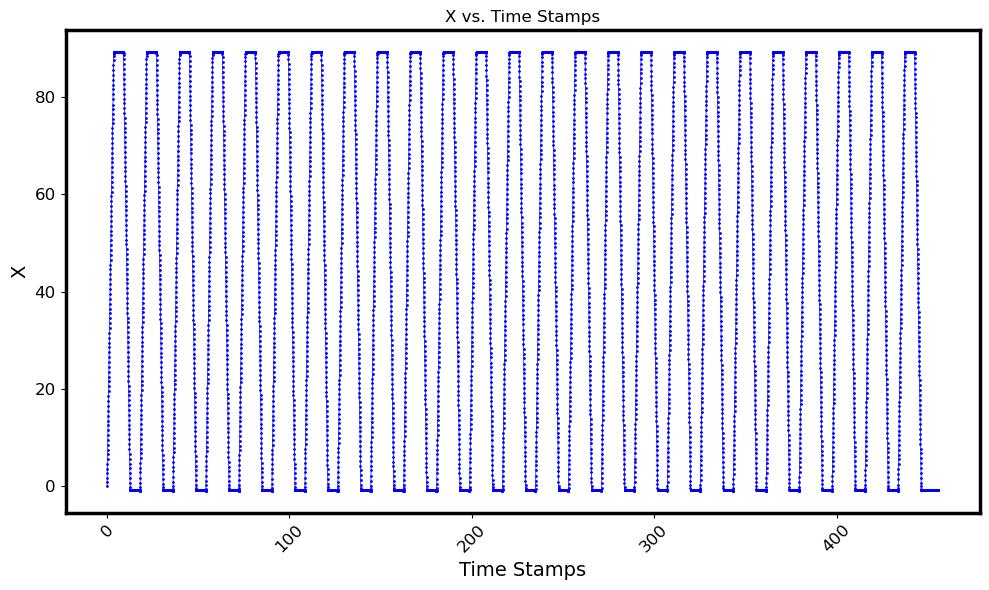

In [16]:
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.plot(df_synchronized_adjusted['Time_Stamps'], df_synchronized_adjusted['X'], marker='o', linestyle='-', color='b', markersize=1, linewidth=0.5)  # Adjust here
plt.title('X vs. Time Stamps')  # Title of the plot
plt.xlabel('Time Stamps')  # Label for the x-axis
plt.ylabel('X')  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [17]:
df_synchronized_adjusted.to_csv ("sample_23_synchronized_adjusted.csv")

In [18]:
file_path = os.path.join(Dataset_path, f'{sample_num}', 'sample_23_synchronized_adjusted.csv') 
df_spatiotemporal_fused = pd.read_csv(file_path)

### Concatenate all the dataset

In [26]:
final_dfs = {}

# Iterate over each sample number to perform the synchronization
for sample in sample_numbers:
    file_path = os.path.join(Dataset_path, f'{sample}', f'sample_{sample}_synchronized_adjusted.csv') 
    df_spatiotemporal_fused =  pd.read_csv(file_path)
    # Store the final DataFrame in the dictionary
    final_dfs[sample] = df_spatiotemporal_fused

# Display the shape of each final DataFrame to verify the synchronization
{sample: final_df.shape for sample, final_df in final_dfs.items()}

{21: (5107, 139),
 22: (4624, 139),
 23: (11396, 139),
 24: (16317, 139),
 26: (10986, 139),
 32: (13528, 139)}

### Save the final consolidated dataset

In [27]:
final_dfs

{21:       sample_index  Time_Stamps  Time_Stamp_Spatial  Sample number  \
 0                1         0.00             0.00000             21   
 1                2         0.04             0.04253             21   
 2                3         0.08             0.07987             21   
 3                4         0.12             0.11998             21   
 4                5         0.16             0.15993             21   
 ...            ...          ...                 ...            ...   
 5102          5103       204.08           204.08090             21   
 5103          5104       204.12           204.12081             21   
 5104          5105       204.16           204.16089             21   
 5105          5106       204.20           204.20091             21   
 5106          5107       204.24           204.24101             21   
 
       Layer number sony_image_file_name     audio_file_name  \
 0              1.0                  NaN     sample_21_1.wav   
 1            

In [28]:
# Save the corrected individual DataFrames to separate h5 files using 'table' format
for sample_num, df in final_dfs.items():
    df.to_hdf(os.path.join(Dataset_path, f'{sample_num}', f'spatiotemporal_fused_{sample_num}.h5'), key='df', mode='w', format='table')

In [29]:
# Combine them into one big DataFrame and save it to an h5 file using 'table' format
final_consolidated_df = pd.concat(final_dfs.values(), ignore_index=True)
final_consolidated_df.to_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df', mode='w', format='table')
final_consolidated_df

,sample_index,Time_Stamps,Time_Stamp_Spatial,Sample number,Layer number,sony_image_file_name,audio_file_name,image_file_name,class_name_v3,X,...,nu11,nu02,nu30,nu21,nu12,nu03,center_x,center_y,contour_area,contour_length
0,1,0.00,0.00000,21,1.0,NaN,sample_21_1.wav,sample_21_1.jpg,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2,0.04,0.04253,21,1.0,NaN,sample_21_2.wav,sample_21_2.jpg,NaN,0.411870,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
2,3,0.08,0.07987,21,1.0,NaN,sample_21_3.wav,sample_21_3.jpg,NaN,1.156490,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
3,4,0.12,0.11998,21,1.0,NaN,sample_21_4.wav,sample_21_4.jpg,Defect-free,2.128660,...,-0.008049,0.062216,0.001940,-0.002304,-0.001599,0.000891,307.440996,230.264496,291865.5,2279.781744
4,5,0.16,0.15993,21,1.0,NaN,sample_21_5.wav,sample_21_5.jpg,Defect-free,3.211670,...,-0.009879,0.065910,0.001738,-0.003345,-0.000898,0.001388,296.636877,229.109962,281970.0,2407.847760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61953,13524,540.92,540.92058,32,NaN,sample_32_13524.png,sample_32_13524.wav,sample_32_13524.jpg,NaN,2.591308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61954,13525,540.96,540.96054,32,NaN,sample_32_13525.png,sample_32_13525.wav,sample_32_13525.jpg,NaN,2.239258,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61955,13526,541.00,541.00053,32,NaN,sample_32_13526.png,sample_32_13526.wav,sample_32_13526.jpg,NaN,1.920654,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61956,13527,541.04,541.04090,32,NaN,sample_32_13527.png,sample_32_13527.wav,sample_32_13527.jpg,NaN,1.796387,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


### Load the data and check

In [30]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal_consolidated = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
# df_multimodal_consolidated = df_multimodal_consolidated.dropna(subset=['class_name_v3'])
df_multimodal_consolidated

,sample_index,Time_Stamps,Time_Stamp_Spatial,Sample number,Layer number,sony_image_file_name,audio_file_name,image_file_name,class_name_v3,X,...,nu11,nu02,nu30,nu21,nu12,nu03,center_x,center_y,contour_area,contour_length
0,1,0.00,0.00000,21,1.0,NaN,sample_21_1.wav,sample_21_1.jpg,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2,0.04,0.04253,21,1.0,NaN,sample_21_2.wav,sample_21_2.jpg,NaN,0.411870,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
2,3,0.08,0.07987,21,1.0,NaN,sample_21_3.wav,sample_21_3.jpg,NaN,1.156490,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
3,4,0.12,0.11998,21,1.0,NaN,sample_21_4.wav,sample_21_4.jpg,Defect-free,2.128660,...,-0.008049,0.062216,0.001940,-0.002304,-0.001599,0.000891,307.440996,230.264496,291865.5,2279.781744
4,5,0.16,0.15993,21,1.0,NaN,sample_21_5.wav,sample_21_5.jpg,Defect-free,3.211670,...,-0.009879,0.065910,0.001738,-0.003345,-0.000898,0.001388,296.636877,229.109962,281970.0,2407.847760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61953,13524,540.92,540.92058,32,NaN,sample_32_13524.png,sample_32_13524.wav,sample_32_13524.jpg,NaN,2.591308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61954,13525,540.96,540.96054,32,NaN,sample_32_13525.png,sample_32_13525.wav,sample_32_13525.jpg,NaN,2.239258,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61955,13526,541.00,541.00053,32,NaN,sample_32_13526.png,sample_32_13526.wav,sample_32_13526.jpg,NaN,1.920654,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61956,13527,541.04,541.04090,32,NaN,sample_32_13527.png,sample_32_13527.wav,sample_32_13527.jpg,NaN,1.796387,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


## Deprecated code below

In [ ]:
# # Function to get the indices of synchronized time stamps in the high-frequency DataFrame
# def get_synchronized_indices(time_high_freq, time_low_freq):
#     if isinstance(time_high_freq, pd.Series):
#         time_high_freq = time_high_freq.to_numpy()
#     if isinstance(time_low_freq, pd.Series):
#         time_low_freq = time_low_freq.to_numpy()
        
#     synchronized_indices = np.zeros_like(time_low_freq, dtype=int)
#     j = 0
    
#     for i in range(len(time_low_freq)):
#         min_diff = float('inf')
#         while j < len(time_high_freq):
#             diff = abs(time_low_freq[i] - time_high_freq[j])
#             if diff < min_diff:
#                 min_diff = diff
#                 synchronized_indices[i] = j
#             else:
#                 break
#             j += 1
            
#     return synchronized_indices

In [ ]:
# Get the synchronized indices
# synchronized_indices = get_synchronized_indices(df_processed_21['Time_Stamp_Spatial'], annotation_21_df['Time_Stamps'])

# # Extract the corresponding rows from the high-frequency DataFrame
# df_synchronized_position = df_processed_21.iloc[synchronized_indices].reset_index(drop=True)

# # Combine the annotation DataFrame and the synchronized position DataFrame
# df_final = pd.concat([annotation_21_df, df_synchronized_position.drop(columns=['Time_Stamp_Spatial'])], axis=1)

# # Adjust the column order
# column_order = ['sample index', 'Time_Stamps'] + [col for col in df_final.columns if col not in ['sample index', 'Time_Stamps']]
# df_final = df_final[column_order]

# df_final

In [ ]:
# df_final.plot('Time_Stamps', 'Speed')

### Data processing pipeline for individual sample

In [ ]:
# Function to create the final consolidated DataFrame
def create_consolidated_dataframe(annotation_df, position_df):
    # Step 1: Process the raw position DataFrame to get the modified DataFrame
    df_processed_position = process_raw_dataframe(position_df)
    annotation_df['Time_Stamps'] = (annotation_df['sample index'] - 1) * 0.04
    
    # Step 2: Get the synchronized indices
    synchronized_indices = get_synchronized_indices(df_processed_position['Time_Stamp_Spatial'], annotation_df['Time_Stamps'])
    
    # Step 3: Extract the corresponding rows from the processed position DataFrame
    df_synchronized_position = df_processed_position.iloc[synchronized_indices].reset_index(drop=True)
    
    # Step 4: Combine the annotation DataFrame and the synchronized position DataFrame
    df_final = pd.concat([annotation_df, df_synchronized_position.drop(columns=['Time_Stamp_Spatial'])], axis=1)
    
    # Step 5: Adjust the column order
    column_order = ['sample index', 'Time_Stamps'] + [col for col in df_final.columns if col not in ['sample index', 'Time_Stamps']]
    df_final = df_final[column_order]
    
    return df_final

In [ ]:
# Test the pipeline function
df_final_test = create_consolidated_dataframe(annotation_21_df, df_position_21_raw)
df_final_test

In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.plot(df_final_test['Time_Stamps'], df_final_test['X'], marker='o', linestyle='-', color='b', markersize=1, linewidth=0.5)  # Adjust here
plt.title('X vs. Time Stamps')  # Title of the plot
plt.xlabel('Time Stamps')  # Label for the x-axis
plt.ylabel('X')  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [ ]:
df_final_test.to_csv("spatiotemporal_fused.csv")

### Data processing pipeline for each samples

1. Separate this big DataFrame (multimodal features) into individual sample DataFrames.
2. Apply the synchronization pipeline for each sample to combine the position information with the existing sensor data features.
3. Reassemble the synchronized DataFrames back into one large DataFrame.

In [ ]:
# Separate the big DataFrame into individual sample DataFrames based on the 'Sample number' column
sample_numbers = [21, 22, 23, 24, 26, 32]
sample_dfs = {sample: df_multimodal[df_multimodal['Sample number'] == sample].reset_index(drop=True) for sample in sample_numbers}

# Display the shape of each individual sample DataFrame to verify the separation
{sample: sample_df.shape for sample, sample_df in sample_dfs.items()}

In [ ]:
for sample, df in sample_dfs.items():
    df['Time_Stamps'] = (df['sample index'] - 1) * 0.04
    
    # Move Time_Stamps column to the front, right after 'sample index'
    cols = df.columns.tolist()
    cols.insert(1, cols.pop(cols.index('Time_Stamps')))
    sample_dfs[sample] = df[cols]

In [ ]:
# Display the first few rows of one of the modified DataFrames to verify
sample_dfs[21]

In [ ]:
final_dfs = {}

# Iterate over each sample number to perform the synchronization
for sample in sample_numbers:
    # Load the corresponding raw position DataFrame
    position_df = pd.read_csv(os.path.join(Dataset_path, f'{sample}', f'position_{sample}_raw.csv') )
    
    # Get the individual sample DataFrame from the big DataFrame
    individual_sample_df = sample_dfs[sample]
    
    # Apply the synchronization pipeline to get the final DataFrame for this sample
    final_df = create_consolidated_dataframe(individual_sample_df, position_df)
    
    # Store the final DataFrame in the dictionary
    final_dfs[sample] = final_df

# Display the shape of each final DataFrame to verify the synchronization
{sample: final_df.shape for sample, final_df in final_dfs.items()}

In [ ]:
final_dfs[22]

the synchronization pipeline has been successfully applied to each individual sample DataFrame. 
- Each resulting DataFrame has 134 columns: 126 columns from the original multimodal DataFrame plus 8 new columns for the position information (X, Y, Z, Vx, Vy, Vz, Speed, Time stamp.).

### Save the final consolidated dataset

In [ ]:
# for col in ['audio_file_name', 'image_file_name', 'class_name', 'class_name_v2', 'class_name_v3']:
#     df_audiovisual[col] = df_audiovisual[col].astype('category')

In [ ]:
final_dfs

In [ ]:
# Save the corrected individual DataFrames to separate h5 files using 'table' format
for sample_num, df in final_dfs.items():
    df.to_hdf(os.path.join(Dataset_path, f'{sample_num}', f'spatiotemporal_fused_{sample_num}.h5'), key='df', mode='w', format='table')

In [ ]:
# Combine them into one big DataFrame and save it to an h5 file using 'table' format
final_consolidated_df = pd.concat(final_dfs.values(), ignore_index=True)
final_consolidated_df.to_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df', mode='w', format='table')

### Load the data and check

In [ ]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal_consolidated = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal_consolidated = df_multimodal_consolidated.dropna(subset=['class_name_v3'])
df_multimodal_consolidated